In [67]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim

# Parameters

In [68]:
N = 30 # time discretization
S0 = 1 # intital value of Stock
X0 = 1 # initial wealth
T = 1 # maturity
sigma = 0.2 # volatility
mu = 0.1 # drift
r = 0.0 # riskless rate
gamma = 0.0
R = 10**5 # number of trajectories
m = 1 # dimension of price

# Scenario Generator

### Sample Generation

In [69]:
# seed to reproduce
np.random.seed(42)

In [70]:
samples_Z_1 = np.random.normal(loc=0, scale=1, size=(m, N+1,R))

#### BS Model

We have the equation $dS_t = \mu S_t dt + \sigma S_t dW_t$ to model the stock prices.

We discretize this and get:
$S_{t + \Delta t} = S_t + \mu S_t \Delta t + \sigma S_t \sqrt{\Delta t} Z_t$

Where $Z_t \sim \mathcal{N}(0, 1)$ 

In [71]:
BS_price_paths = np.zeros((m, N+1, R))
BS_price_paths[0, 0, :] = S0 

In [72]:
for i in range(R):
    S_t = S0
    for j in range(N):
        sample = samples_Z_1[0, j, i]
        S_t += mu * S_t * T/N + sigma * S_t * np.sqrt(T/N) * sample
        BS_price_paths[0, j+1, i] = S_t

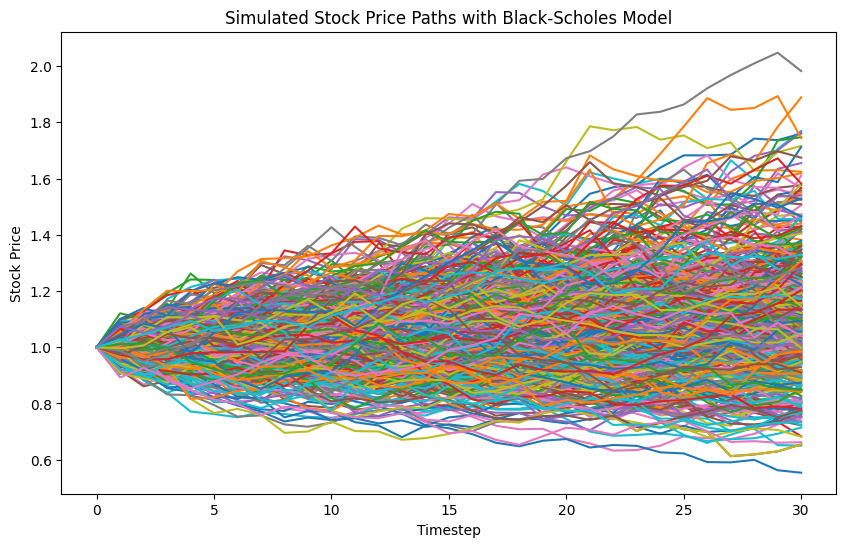

In [48]:
plt.figure(figsize=(10, 6))
paths = np.random.choice(R, 500)
for i in paths:
    plt.plot(BS_price_paths[0, :,i])# , label=f'Path {i+1}')
plt.xlabel('Timestep')
plt.ylabel('Stock Price')
plt.title('Simulated Stock Price Paths with Black-Scholes Model')
# plt.legend()
plt.show()

### CEV Model

For this model we have this descretisation looks like this $S_{t + \Delta t} = S_t + \mu S_t \Delta t + \sigma S^{\gamma}_t \sqrt{\Delta t}Z_T$

This is very similar to the BS model. The major difference is that we have a $\gamma$ parameter that puts the volatility and the price into relationship. Meaning here the Volatility of the stock depends on the Price of the Stock.

Some typical values are:

$\gamma \lt 1$: volatility increases when prices fall. This typically can be seen in equity markets

$\gamma \gt 1$: Volatility increases when prices rise. This can be seen for example in the commodity markets.

$\gamma = 1$: the then results in geometric Brownian Motion and then the CEV model is just the standard BS Model

In [49]:
# specify additional Parameters
gamma_cev = 1.0

CEV_price_paths = np.zeros((m, N+1, R))
CEV_price_paths[0, 0, :] = S0

In [50]:
for i in range(R):
    S_t = S0
    for j in range(N):
        sample = samples_Z_1[0, j, i]
        S_t += mu * S_t * T/N + sigma * S_t**gamma * np.sqrt(T/N) * sample
        CEV_price_paths[0, j+1, i] = S_t

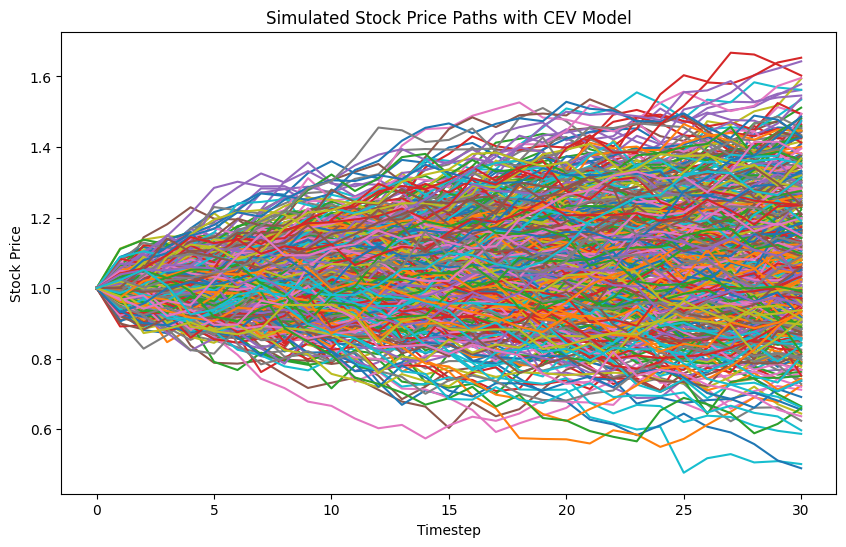

In [51]:
plt.figure(figsize=(10, 6))
paths = np.random.choice(R, 500)
for i in paths:
    plt.plot(CEV_price_paths[0, :,i])# , label=f'Path {i+1}')
plt.xlabel('Timestep')
plt.ylabel('Stock Price')
plt.title('Simulated Stock Price Paths with CEV Model')
# plt.legend()
plt.show()

### Heston Model

Now we have the following discretization.

Volatility Process:
$$
\nu_{t + \Delta t} = \nu_t + \kappa(\theta - \nu_t)\Delta t + \xi \sqrt{\nu_t}\sqrt{\Delta t}Z^2_t
$$

Stock Price Process:
$$
S_{t + \Delta t} = S_t + \mu S_t \Delta t + \sqrt{\nu_t}S_t\sqrt{\Delta t}Z^1_t
$$

Correlated Random Variables:
$$
Z^2_t = \rho Z^1_t + \sqrt{1-\rho^2}Z^3_t
$$
where $Z^1_t, Z^3_t \sim \mathcal{N}(0,1)$

In [161]:
# additional parameters and samples
samples_Z_3 = np.random.normal(loc=0, scale=1, size=(N,timesteps))

xi = 0.35
nu_0 = 0.025
theta = 0.04
kappa = 1
rho = -0.7

NameError: name 'timesteps' is not defined

In [11]:
samples_Z_2 = rho*samples_Z_1 + np.sqrt(1-rho**2)*samples_Z_3

In [12]:
heston_price_paths = np.zeros([N,timesteps+1])
heston_vol_paths = np.zeros([N,timesteps+1])

heston_price_paths[:,0] = S_0
heston_vol_paths[:,0] = nu_0

In [13]:
for i in range(N):
    log_S_t = np.log(S_0)
    nu_t = nu_0
    for t in range(timesteps):
        sample_Z_2 = samples_Z_2[i, t]
        sample_Z_1 = samples_Z_1[i, t]

        # Variance update (Euler-Maruyama)
        new_nu = nu_t + kappa * (theta - nu_t) * delta_t + xi * np.sqrt(np.maximum(nu_t, 0)) * np.sqrt(delta_t) * sample_Z_2
        new_nu = np.maximum(new_nu, 0)  # Ensure non-negativity

        # Log-price update
        log_S_t += (mu - 0.5 * nu_t) * delta_t + np.sqrt(np.maximum(nu_t, 0)) * np.sqrt(delta_t) * sample_Z_1
        new_value = np.exp(log_S_t)

        heston_price_paths[i, t + 1] = new_value
        heston_vol_paths[i, t + 1] = new_nu

        nu_t = new_nu


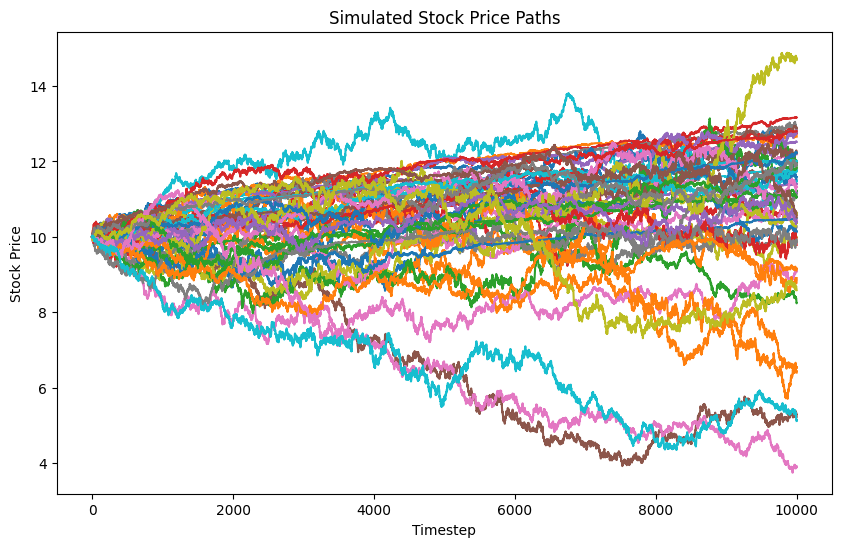

In [14]:
plt.figure(figsize=(10, 6))
paths = np.random.choice(N, 50)
for i in paths:
    plt.plot(heston_price_paths[i])# , label=f'Path {i+1}')
plt.xlabel('Timestep')
plt.ylabel('Stock Price')
plt.title('Simulated Stock Price Paths')
# plt.legend()
plt.show()

For the Heston Model we have the risk of having negativ $\nu_{t + \Delta t}$ values which would mean negative variance and would then be used in the np.sqrt function. This does not make sense. currently i clip the variance just at 0 but there are other possibilities to resolve this. Maybe look into this.

### Comparison of Paths

In [55]:
paths = np.random.choice(R, 10)

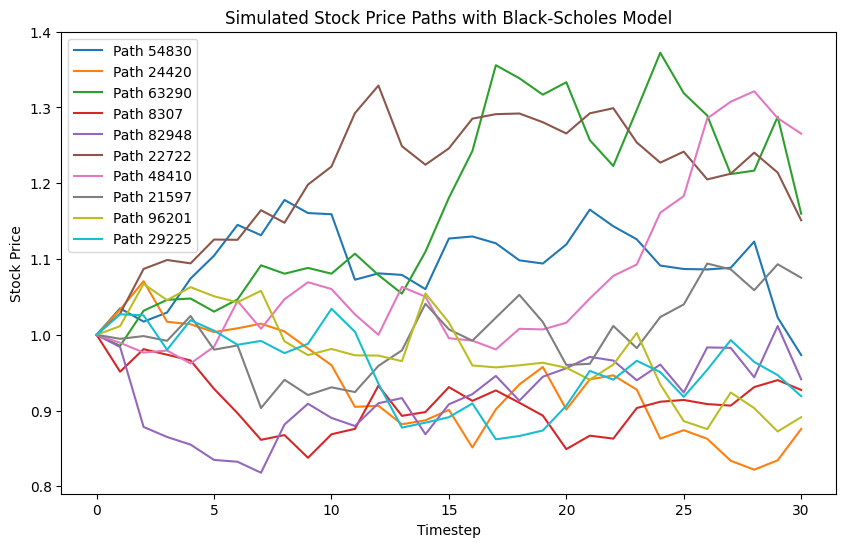

In [57]:
plt.figure(figsize=(10, 6))
for i in paths:
    plt.plot(BS_price_paths[0, :,i], label=f'Path {i+1}')
plt.xlabel('Timestep')
plt.ylabel('Stock Price')
plt.title('Simulated Stock Price Paths with Black-Scholes Model')
plt.legend()
plt.show()

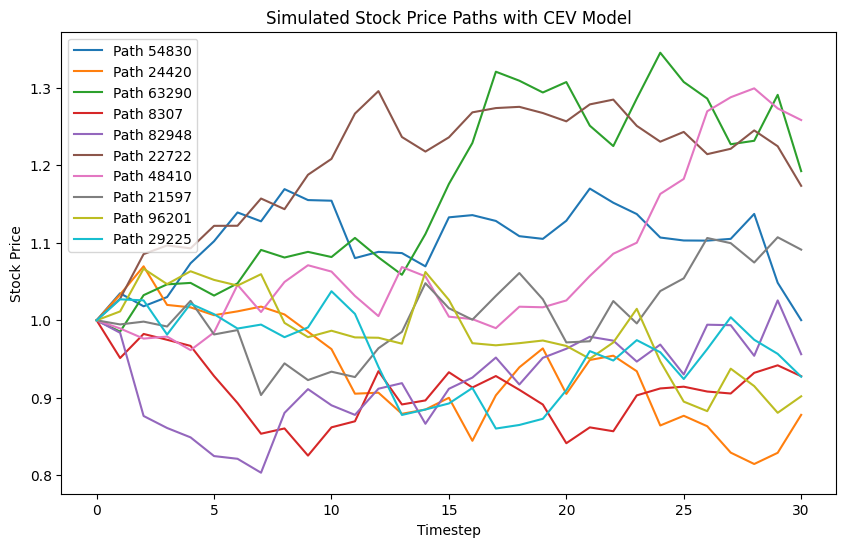

In [58]:
plt.figure(figsize=(10, 6))
for i in paths:
    plt.plot(CEV_price_paths[0, :,i], label=f'Path {i+1}')
plt.xlabel('Timestep')
plt.ylabel('Stock Price')
plt.title('Simulated Stock Price Paths with CEV Model')
plt.legend()
plt.show()

In [59]:
CEV_price_paths.shape

(1, 31, 100000)

In [60]:
BS_price_paths.shape

(1, 31, 100000)

In [64]:
BS_price_paths[0,30,63289]

np.float64(1.159795518142462)

In [65]:
CEV_price_paths[0,30,63289]

np.float64(1.1924078504114166)

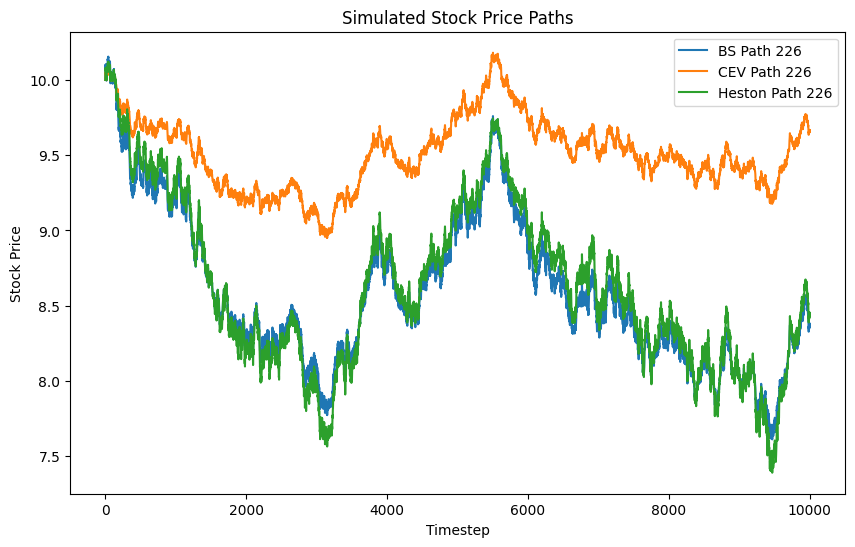

In [15]:
plt.figure(figsize=(10, 6))
paths = np.random.choice(N, 1)
for i in paths:
    plt.plot(BS_price_paths[i], label=f'BS Path {i+1}')
    plt.plot(CEV_price_paths[i], label=f'CEV Path {i+1}')
    plt.plot(heston_price_paths[i], label=f'Heston Path {i+1}')
plt.xlabel('Timestep')
plt.ylabel('Stock Price')
plt.title('Simulated Stock Price Paths')
plt.legend()
plt.show()

# Markovian Approach

### Network

In [409]:
# additional Parameters
d = 3 # number of layers
n = 32 # hidden dimension

In [ ]:
class StrategyBlock(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(StrategyBlock, self).__init__()

        self.layers = nn.ModuleList()

        first_layer = nn.Linear(input_dim, hidden_dim)
        nn.init.normal_(first_layer.weight, mean=0.0, std=0.5)
        nn.init.normal_(first_layer.bias, mean=0.0, std=0.5)
        self.layers.append(first_layer)

        for i in range(1, num_layers-1):
            layer = nn.Linear(hidden_dim, hidden_dim)
            nn.init.normal_(layer.weight, mean=0.0, std=0.5)
            nn.init.normal_(layer.bias, mean=0.0, std=0.5)
            self.layers.append(layer)
        
        last_layer = nn.Linear(hidden_dim, output_dim)
        nn.init.normal_(last_layer.weight, mean=0.0, std=0.5)
        nn.init.normal_(last_layer.bias, mean=0.0, std=0.5)
        self.layers.append(last_layer)
    
    def forward(self, x):
        for layer in self.layers[:-1]:
            x = torch.tanh(layer(x))
        
        x = self.layers[-1](x)
        return x

class MarkovTrader(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, model_params):
        super(MarkovTrader, self).__init__()

        self.model_params = model_params

        self.block = StrategyBlock(input_dim, hidden_dim, output_dim, num_layers)
    
    def forward(self, x):
        r = self.model_params['r']
        
        N = self.model_params['N']
        R = self.model_params['R']
        T = self.model_params['T']
        sigma = self.model_params['sigma']
        m = self.model_params['m']

        wealth = x[0, N+1, :]

        strategies = []
        wealthpath = []

        wealthpath.append(wealth)

        for j in range(N):
            price = x[0, j, :]

            time = torch.full(size=(R,m), fill_value=j*(T/N))
            
            input = torch.cat([time, price.unsqueeze(1), wealth.unsqueeze(1)], dim=1) # shape (R, m*3)

            # inputeval = tradeeval

            strategy = self.block(input)
            strategy = strategy.squeeze(1)
            strategies.append(strategy)


            logreturns = torch.log(x[0, j+1, :]) - torch.log(price)

            logwealth = torch.log(wealth) + strategy*logreturns + (1-strategy)*r*(T/N) - strategy**2*sigma**2*T/(2*N)

            newwealth = torch.exp(logwealth)


            # outputhelper = outputhelper + [strategyeval]

            wealth = newwealth
            wealthpath.append(wealth)
        
        outputs = wealth
        strategies = torch.stack(strategies, dim=0) 
        wealthpath = torch.stack(wealthpath, dim=0)
        # outputs = [outputs] + outputhelper
        # outputs = torch.cat(outputs, dim=1)

        return outputs, wealthpath, strategies


### Training

In [603]:
BS_tensor = torch.from_numpy(BS_price_paths).float()
wealth = np.ones(shape=(m, 1, R))
wealth_tensor = torch.from_numpy(wealth).float()
trade = np.zeros(shape=(1, 1, R))
trade_tensor = torch.from_numpy(trade).float()
tradeeval = np.ones(shape=(m, 1, R))
tradeeval_tensor = torch.from_numpy(tradeeval).float()

In [604]:
x_train = torch.cat([BS_tensor, wealth_tensor, trade_tensor], dim=1)
y_train = torch.zeros(x_train.shape[0])

dataset = TensorDataset(x_train, y_train)
loader = DataLoader(dataset, batch_size=1000, shuffle=True)

In [570]:
input_dim = m*3
hidden_dim = n
output_dim = m
d = 3
depth = N

model_params = {
    'r': r,
    'N': N,
    'R': R,
    'T': T,
    'sigma': sigma,
    'm': m
}

model = MarkovTrader(input_dim, hidden_dim, output_dim, d, model_params)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [571]:
def custom_loss(y_true, y_pred, gamma):
    # y_pred[:, 0] selects the first column
    if gamma == 0.0:
        util = torch.log(y_pred)
    else:
        util = (y_pred ** (gamma)-1) / gamma
    loss = -torch.mean(util)
    return loss

In [ ]:
num_epochs = 100

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    i = 1
    for batch in loader:
        print(f'batch {i}')
        i += 1
        x_batch, y_batch = batch

        optimizer.zero_grad()

        y_pred, wealthpaths, strats = model(x_batch)

        loss = custom_loss(y_batch, y_pred, gamma=gamma)

        loss.backward()

        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(loader):.4f}")


batch 1
pricepath shape: torch.Size([100000, 1])
weahlpath tensor shape: torch.Size([100000, 1])
input shape: torch.Size([100000, 10, 2])
strategy shape: torch.Size([100000, 1])
pricepath shape: torch.Size([100000, 2])
weahlpath tensor shape: torch.Size([100000, 2])
input shape: torch.Size([100000, 10, 2])
strategy shape: torch.Size([100000, 1])
pricepath shape: torch.Size([100000, 3])
weahlpath tensor shape: torch.Size([100000, 3])
input shape: torch.Size([100000, 10, 2])
strategy shape: torch.Size([100000, 1])
pricepath shape: torch.Size([100000, 4])
weahlpath tensor shape: torch.Size([100000, 4])
input shape: torch.Size([100000, 10, 2])
strategy shape: torch.Size([100000, 1])
pricepath shape: torch.Size([100000, 5])
weahlpath tensor shape: torch.Size([100000, 5])
input shape: torch.Size([100000, 10, 2])
strategy shape: torch.Size([100000, 1])
pricepath shape: torch.Size([100000, 6])
weahlpath tensor shape: torch.Size([100000, 6])
input shape: torch.Size([100000, 10, 2])
strategy sha

### Evaluation

In [45]:
logX = np.zeros((N+1, R))
logX[0,] = np.log(X0)*np.ones((1,R))
alphastar = (mu - r)/(sigma**2*(1-gamma))
for i in range(R):
    for j in range(N):
        logreturns = np.log(BS_price_paths[0, j+1, i]) - np.log(BS_price_paths[0,j,i])
        logX[j+1, i] = logX[j,i] + alphastar*logreturns + (1-alphastar)*r*T/N - alphastar**2*sigma**2*T/(2*N)
        # increment = np.random.normal(mu*T/N,sigma*np.sqrt(T)/np.sqrt(N))
        # logX[j+1,i] =logX[j,i]+increment*alphastar+r*T/N*(1-alphastar)-alphastar**2*sigma**2*T/(2*N)


In [46]:
X = np.exp(logX)
if gamma == 0.0:
    util = np.log(X[N,:])
else:
    util = (X[N,:] ** (gamma)-1) / gamma
loss = -np.mean(util)
print(loss)

-0.07348917340384417


In [47]:
print(np.mean(X[N,:]))
print(np.std(X[N,:]))
print(np.max(X[N,:]))

1.2196559126708197
0.6500576742322058
8.590145893655134


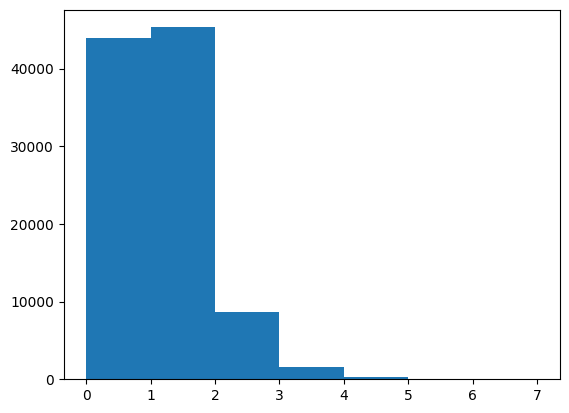

In [48]:
bins = np.arange(0, 8, 1)
plt.hist(X[N,:], bins=bins)
plt.show()

In [579]:
y_pred, wealthpaths, strategies = model(x_train)

shape of x: torch.Size([1, 33, 100000])


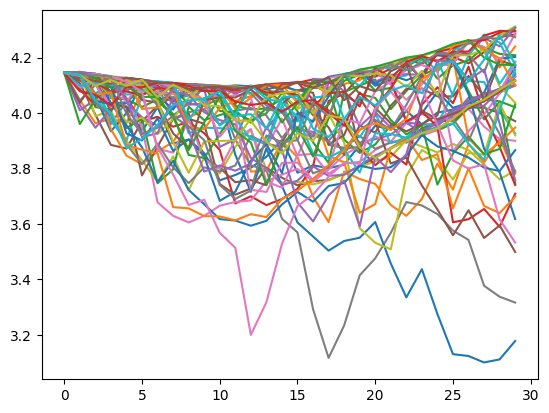

In [ ]:
strats = np.random.choice(R, 50)
for i in strats:
    plt.plot(strategies[:,i].detach().cpu().numpy())
plt.show()

In [581]:
print(y_pred.mean())
print(y_pred.std())
print(y_pred.max())

tensor(1.3732, grad_fn=<MeanBackward0>)
tensor(1.2508, grad_fn=<StdBackward0>)
tensor(33.6385, grad_fn=<MaxBackward1>)


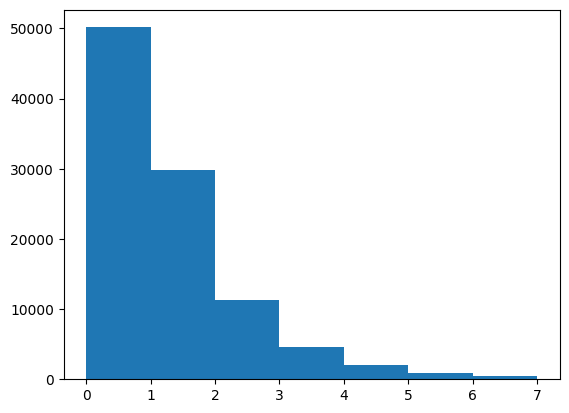

In [582]:
bins = np.arange(0, 8, 1)
plt.hist(y_pred.detach().cpu().numpy(), bins=bins)
plt.show()

In [595]:
strats = np.random.choice(R, 10)

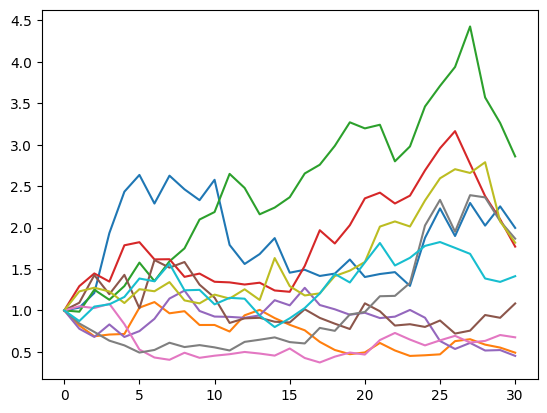

In [596]:
for i in strats:
    plt.plot(wealthpaths[:,i].detach().cpu().numpy())
plt.show()

In [601]:
utilitypaths = (wealthpaths**(gamma)-1)/gamma

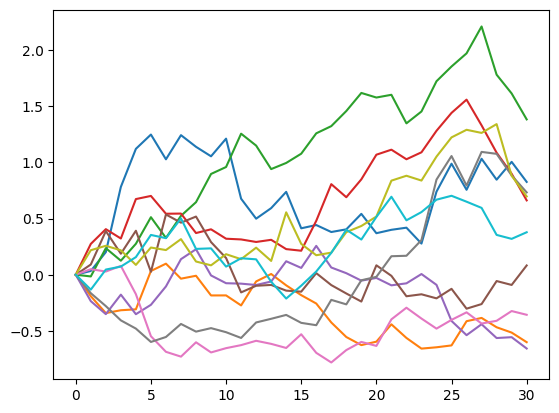

In [602]:
for i in strats:
    plt.plot(utilitypaths[:,i].detach().cpu().numpy())
plt.show()

# Path dependent Approach

### Network

In [9]:
def padding(seq, target_length):
    length = seq.size(1)
    if length < target_length:
        padding = torch.zeros(seq.size(0), target_length - length, seq.size(2), dtype=seq.dtype, device=seq.device)
        return torch.cat([padding, seq], dim=1)
    else:
        return seq[:, -target_length:, :]


In [52]:
class LSTMBlock(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTMBlock, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)

        out, _ = self.lstm(x, (h0,c0))
        out = self.fc(out[:, -1, :])

        return out
    
class IntelligentTrader(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, model_params):
        super(IntelligentTrader, self).__init__()

        self.series_length = 10

        self.model_params = model_params

        self.block = LSTMBlock(input_dim, hidden_dim, layer_dim, output_dim)

    def forward(self, x):
        r = self.model_params['r']
        
        N = self.model_params['N']
        R = self.model_params['R']
        T = self.model_params['T']
        sigma = self.model_params['sigma']
        m = self.model_params['m']

        wealth = x[:, 0, N+1]

        wealthpath = []
        strategies = []
        wealthpath.append(wealth)

        for j in range(N):
            wealthpath_tensor = torch.stack(wealthpath,dim=0)
            wealthpath_tensor = wealthpath_tensor.transpose(0,1)
            pricepaths = x[:, 0, 0:j+1]

            input = torch.cat([pricepaths.unsqueeze(-1), wealthpath_tensor.unsqueeze(-1)], dim=-1)

            input = padding(input, self.series_length)

            print(f'input shape: {input.shape}')

            strategy = self.block(input)
            strategy = strategy.squeeze(1)
            strategies.append(strategy)

            logreturns = torch.log(x[:, 0, j+1]) - torch.log(x[:, 0, j])

            logwealth = torch.log(wealth) + strategy*logreturns + (1-strategy)*r*(T/N) - strategy**2*sigma**2*T/(2*N)

            newwealth = torch.exp(logwealth)

            wealth = newwealth
            wealthpath.append(wealth)
        
        outputs = wealth
        strategies = torch.stack(strategies, dim=0) 
        wealthpath = torch.stack(wealthpath, dim=0)

        return outputs, wealthpath, strategies

In [53]:
BS_tensor = torch.from_numpy(BS_price_paths).float()
wealth = np.ones(shape=(m, 1, R))
wealth_tensor = torch.from_numpy(wealth).float()
trade = np.zeros(shape=(1, 1, R))
trade_tensor = torch.from_numpy(trade).float()
tradeeval = np.ones(shape=(m, 1, R))
tradeeval_tensor = torch.from_numpy(tradeeval).float()

In [54]:
BS_tensor = BS_tensor.permute(-1, *range(BS_tensor.ndim - 1))  # Moves last dim to front
wealth_tensor = wealth_tensor.permute(-1, *range(wealth_tensor.ndim - 1))
trade_tensor = trade_tensor.permute(-1, *range(trade_tensor.ndim - 1))

In [55]:
BS_tensor.shape

torch.Size([100000, 1, 31])

In [56]:
wealth_tensor.shape

torch.Size([100000, 1, 1])

In [57]:
x_train = torch.cat([BS_tensor, wealth_tensor, trade_tensor], dim=2)
y_train = torch.zeros(x_train.shape[0])

dataset = TensorDataset(x_train, y_train)
loader = DataLoader(dataset, batch_size=50000, shuffle=True)

In [58]:
x_train.shape

torch.Size([100000, 1, 33])

In [59]:
input_dim = m+1
hidden_dim = 50
layer_dim = 1
output_dim = m
d = 3
depth = N

model_params = {
    'r': r,
    'N': N,
    'R': R,
    'T': T,
    'sigma': sigma,
    'm': m
}

model = IntelligentTrader(input_dim, hidden_dim, layer_dim, output_dim, model_params)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [60]:
def custom_loss(y_true, y_pred, gamma):
    # y_pred[:, 0] selects the first column
    if gamma == 0.0:
        util = torch.log(y_pred)
    else:
        util = (y_pred ** (gamma)-1) / gamma
    loss = -torch.mean(util)
    return loss

In [ ]:
num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for batch in loader:
        x_batch, y_batch = batch

        optimizer.zero_grad()

        y_pred, wealthpaths, strats = model(x_batch)

        loss = custom_loss(y_batch, y_pred, gamma=gamma)

        loss.backward()

        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(loader):.4f}")


In [49]:
y_pred, wealthpaths, strategies = model(x_train)

In [50]:
print(y_pred.mean())
print(y_pred.std())
print(y_pred.max())

tensor(1.1933, grad_fn=<MeanBackward0>)
tensor(0.5744, grad_fn=<StdBackward0>)
tensor(8.2828, grad_fn=<MaxBackward1>)


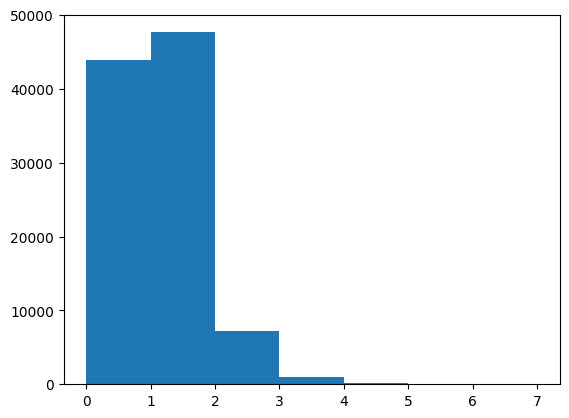

In [51]:
bins = np.arange(0, 8, 1)
plt.hist(y_pred.detach().cpu().numpy(), bins=bins)
plt.show()